In [2]:
#%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


In [3]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '6ed9d167-b2e6-41b8-9500-35e6df64d9dc'
resource_group = 'MLRG'
workspace_name = 'erbbimlws'

workspace = Workspace(subscription_id, resource_group, workspace_name)



Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code DYURB73QV to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.


In [14]:
df = Dataset.get_by_name(workspace, name='Time_Deposits_Data_Set')
df.to_pandas_dataframe()

,Customer_ID,Gender,Birth_Date,Ref_Date,Marital_Status,Children_Num,Occupation_Category,Total_Income,Payroll_Flag,Business_Flag,...,Transfer_Trans_Amount,Credit_Cards_Installments,Credit_Cards_Payments_Num,Credit_Cards_Purchases_Num,Credit_Cards_Witrhdrawals_Num,Credit_Cards_Payments_Amount,Credit_Cards_Purchases_Amount,Credit_Cards_Witrhdrawals_Amount,Arrears_Months_Max,Time_Deposits_Flag
0,36163,Male,1968-01-20,2008-12-31,Single,0,Employees,17637,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,1,False
1,5904434,Male,1973-04-07,2008-12-31,Single,0,Rentiers,5800,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,1,False
2,5904453,Male,1960-10-17,2008-12-31,Married,2,Rentiers,14000,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,1,False
3,855752,Male,1969-07-28,2008-12-31,Married,2,Business-Owners,54814,0,0,...,105.000000,1.666667,0.666667,1.0,0.0,141.666666,230.45,0.0,1,False
4,81,Male,1950-07-27,2008-12-31,Married,2,Employees,64988,0,0,...,0.000000,0.666667,0.666667,0.0,0.0,603.816666,0.00,0.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,5902524,Male,1972-07-22,2008-12-31,Married,2,Employees,30647,1,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0,False
119996,5902564,Male,1978-09-30,2008-12-31,Single,0,Business-Owners,65714,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0,True
119997,5902614,Female,1984-11-26,2008-12-31,Married,0,Employees,4730,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0,False
119998,5902625,Male,1968-02-21,2008-12-31,Married,2,Business-Owners,30476,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,1,False


In [16]:
df = df.to_pandas_dataframe()

AttributeError: 'DataFrame' object has no attribute 'to_pandas_dataframe'

In [18]:
df.head()
df.dtypes

Customer_ID                                  int64
Gender                                      object
Birth_Date                          datetime64[ns]
Ref_Date                            datetime64[ns]
Marital_Status                              object
Children_Num                                 int64
Occupation_Category                         object
Total_Income                                 int64
Payroll_Flag                                 int64
Business_Flag                                int64
Saving_Current_Accounts_Flag               float64
Investment_Products_Flag                   float64
Insurance_Products_Flag                    float64
Business_Loans_Flag                        float64
Housing_Loans_Flag                         float64
Consumer_Loans_Flag                        float64
Credit_Cards_Flag                          float64
Saving_Current_Balance                     float64
Investment_Products_Balance                float64
Insurance_Balances             

In [7]:
def full_log_likelihood(w, X, y):
    score = np.dot(X, w).reshape(1, X.shape[0])
    return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)

def null_log_likelihood(w, X, y):
    z = np.array([w if i == 0 else 0.0 for i, w in enumerate(w.reshape(1, X.shape[1])[0])]).reshape(X.shape[1], 1)
    score = np.dot(X, z).reshape(1, X.shape[0])
    return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)

def mcfadden_rsquare(w, X, y):
    return 1.0 - (full_log_likelihood(w, X, y) / null_log_likelihood(w, X, y))

def mcfadden_adjusted_rsquare(w, X, y):
    k = float(X.shape[1])
    return 1.0 - ((full_log_likelihood(w, X, y) - k) / null_log_likelihood(w, X, y))
def efron_rsquare(y, y_pred):
    n = float(len(y))
    t1 = np.sum(np.power(y - y_pred, 2.0))
    t2 = np.sum(np.power((y - (np.sum(y) / n)), 2.0))
    return 1.0 - (t1 / t2)
def true_probabilities (p,a):
    tp =p/(p+(1-p)/a)
    return tp

In [19]:
recode = {True:"1",False:"0"}

df['Time_Deposits_Flag'] = df['Time_Deposits_Flag'].map(recode)
df['Time_Deposits_Flag'].astype(int)

0         0
1         0
2         0
3         0
4         0
         ..
119995    0
119996    1
119997    0
119998    0
119999    0
Name: Time_Deposits_Flag, Length: 120000, dtype: int64

In [20]:
df['Time_Deposits_Flag'].value_counts()

0    118663
1      1337
Name: Time_Deposits_Flag, dtype: int64

In [21]:
for col in df.columns[1:-1]:       
       if df[col].dtype =='object' and col not in ['Birth_Date','Ref_Date']:
            
            df = pd.get_dummies(df, prefix=col + '_', columns=[col])

In [22]:
for col in df.columns[1:-1]:       
       if df[col].dtype =='float' and ('_Num' in col or '_Flag' in col):
            
            df[col] = df[col].astype('int')

In [23]:
df['Total_Income'] = df['Total_Income'].astype('float')

In [24]:
df['Time_Deposits_Flag'] = df['Time_Deposits_Flag'].astype('int')

In [25]:
df = df.drop(['Birth_Date','Ref_Date'],axis = 1)

In [26]:
X = df[df.columns[1:]].drop(['Time_Deposits_Flag'],axis = 1)

In [27]:
y = df['Time_Deposits_Flag']

In [28]:
f_count = df[df['Time_Deposits_Flag']== 0].iloc[:,0].count()
t_count = df[df['Time_Deposits_Flag']== 1].iloc[:,0].count()
weights = {1:1,0:t_count*3/f_count}

In [34]:
LR = LogisticRegression(class_weight = 'balanced',solver = 'liblinear',max_iter = 1000  )

In [35]:
selector = RFE(LR)

In [36]:
selector.fit(X,y)

RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=1000,
                                 multi_class='auto', n_jobs=None, penalty='l2',
                                 random_state=None, solver='liblinear',
                                 tol=0.0001, verbose=0, warm_start=False),
    n_features_to_select=None, step=1, verbose=0)

In [37]:
print(classification_report(y,  selector.predict(X)))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76    118663
           1       0.02      0.71      0.04      1337

    accuracy                           0.62    120000
   macro avg       0.51      0.66      0.40    120000
weighted avg       0.98      0.62      0.76    120000



In [38]:
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(selector.score(X, y)))

Accuracy of logistic regression classifier on train set: 0.6207


In [39]:
y_pred = selector.predict(X)

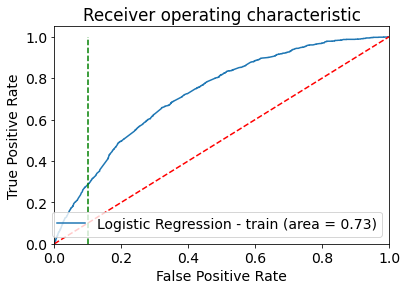

In [40]:
logit_roc_auc = roc_auc_score(y, selector.predict(X))
fpr, tpr, thresholds = roc_curve(y, selector.predict_proba(X)[:,1])
auc_train = roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='Logistic Regression - train (area = %0.2f)' % auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.plot([0.1,0.1],[0,1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [41]:
df_lift = pd.DataFrame(zip(y,selector.predict_proba(X)[:,1]),columns =['Actual','Predicted']).sort_values(by ='Predicted',ascending = False)

In [42]:
'lift at 10% is {:.03f}'.format(df_lift['Actual'].head(12000).sum()/df_lift['Actual'].sum()/0.1)

'lift at 10% is 2.820'

In [43]:
pd.DataFrame(zip(X.columns[selector.support_],selector.ranking_),columns=['Column','Importance']).sort_values(by ='Importance')

,Column,Importance
25,Occupation_Category__default,1
20,Marital_Status__Widow,1
21,Occupation_Category__Business-Owners,1
10,Phone_Trans_Num,1
9,APS_Trans_Num,1
7,Credit_Cards_Flag,1
8,Branch_Trans_Num,1
5,Housing_Loans_Flag,1
4,Business_Loans_Flag,1
3,Insurance_Products_Flag,1
